# Rosembrock Target Practice

In [1]:
using Pkg
Pkg.activate("..")
Pkg.resolve()
Pkg.instantiate()

  Activating project at `~/PhD/MicroCanonicalHMC.jl/examples`
  No Changes to `~/PhD/MicroCanonicalHMC.jl/examples/Project.toml`
  No Changes to `~/PhD/MicroCanonicalHMC.jl/examples/Manifest.toml`


In [2]:
using Distributions
using ForwardDiff
using LinearAlgebra
using Random
#using StatsPlots
using PyPlot
using Distributed

using Revise
using MicroCanonicalHMC

[ Info: Precompiling PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
[ Info: Precompiling MicroCanonicalHMC [234d2aa0-2291-45f7-9047-6fa6f316b0a8]


## MCHMC

In [4]:
target = RosenbrockTarget(1.0, 10.0, 2);

In [5]:
X = LinRange(-3, 5, 100)
Y = LinRange(-2, 18, 100)
Z = zeros(length(X), length(Y))
for i in 1:length(X)
    for j in 1:length(Y)
        x = X[i]
        y = Y[j]
        Z[i, j] = exp(target.h.ℓπ([x; y]))
    end
end

In [6]:
d2_truth = vec(normalize(sum(Z, dims=1)))
d1_truth = vec(normalize(sum(Z, dims=2)))

100-element Vector{Float64}:
 7.162829369412773e-5
 9.863809139860455e-5
 0.00013494872801976375
 0.0001834243594214731
 0.0002476904756917828
 0.000332296436430068
 0.000442900469948504
 0.0005864765865858889
 0.0007715415106920719
 0.0010083980468276281
 0.001309389262123287
 0.001689155512694095
 0.0021648837232836893
 ⋮
 0.0016890587797713194
 0.001251217459171278
 0.00031134149060358854
 2.3604574783005898e-6
 1.5088638240128408e-10
 4.865587974811031e-17
 5.648489440875084e-26
 1.7465706115620848e-37
 1.0692541153538504e-51
 9.6070764266984e-69
 9.347706927905418e-89
 7.231720986524703e-112

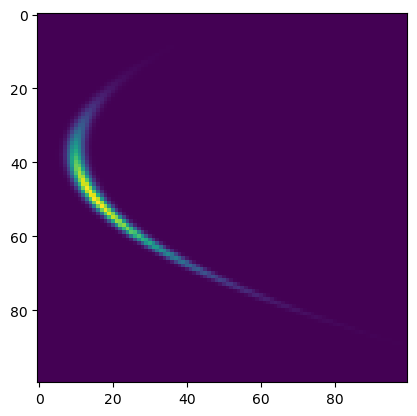

PyObject <matplotlib.image.AxesImage object at 0x7fc8a9549e50>

In [7]:
plt.imshow(Z)

In [8]:
d = 2
spl = MCHMC(10_000, 0.01;
    L=sqrt(2), sigma=ones(target.d),
    tune_L=false, tune_sigma=false, adaptive=true)

MicroCanonicalHMC.MCHMCSampler(10000, 0.01, true, true, false, false, MicroCanonicalHMC.Hyperparameters{Float64}(0.0, 1.4142135623730951, 0.0, 0.0, [1.0, 1.0], 0.0, 0.0, 0.0, 0.0), MicroCanonicalHMC.Leapfrog)

In [9]:
samples_mchmc = Sample(spl, target, 500_000; dialog=true);

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter ~/.julia/packages/ProgressMeter/vnCY0/src/ProgressMeter.jl:626
MCHMC: 100%|████████████████████████████████████████████| Time: 0:00:11


In [12]:
d1_mchmc = samples_mchmc[1, :]
d2_mchmc = samples_mchmc[2, :];

In [13]:
d1_mchmc

500000-element Vector{Float64}:
 0.6595021771501662
 0.7300539348237838
 0.8409489987101277
 0.9412277072592
 1.0183608492273326
 1.07928468796976
 1.054851470722163
 0.9174849687049944
 0.7993282654843259
 0.6610708408676348
 0.5742296245849727
 0.6384182423907692
 0.6721344993557883
 ⋮
 1.4083874890808692
 1.495430300533695
 1.4121252489313283
 1.519395790799471
 1.6614860778848615
 1.5799001703094409
 1.5974759238249971
 1.7528103798398087
 1.7940089365858158
 1.68078153517712
 1.8045895086315418
 1.8931952304269317

## NUTS

In [14]:
using AdvancedHMC
using LogDensityProblems

In [15]:
# Define the target distribution using the `LogDensityProblem` interface
struct LogTargetDensity
    dim::Int
end
LogDensityProblems.logdensity(p::LogTargetDensity, θ) = target.h.ℓπ(θ) #-sum(abs2, θ) / 2  # standard multivariate normal
LogDensityProblems.dimension(p::LogTargetDensity) = p.dim
LogDensityProblems.capabilities(::Type{LogTargetDensity}) = LogDensityProblems.LogDensityOrder{0}()

In [20]:
# Choose parameter dimensionality and initial parameter value
initial_θ = target.θ_start
ℓπ = LogTargetDensity(target.d)

# Set the number of samples to draw and warmup iterations
n_samples, n_adapts = 100_000, 10_000

# Define a Hamiltonian system
metric = DiagEuclideanMetric(target.d)
hamiltonian = Hamiltonian(metric, ℓπ, ForwardDiff)

# Define a leapfrog solver, with initial step size chosen heuristically
initial_ϵ = find_good_stepsize(hamiltonian, initial_θ)
integrator = AdvancedHMC.Leapfrog(initial_ϵ)

# Define an HMC sampler, with the following components
#   - multinomial sampling scheme,
#   - generalised No-U-Turn criteria, and
#   - windowed adaption for step-size and diagonal mass matrix
kernel = HMCKernel(Trajectory{MultinomialTS}(integrator, GeneralisedNoUTurn()))
adaptor = StanHMCAdaptor(MassMatrixAdaptor(metric), StepSizeAdaptor(0.9, integrator))

# Run the sampler to draw samples from the specified Gaussian, where
#   - `samples` will store the samples
#   - `stats` will store diagnostic statistics for each sample
samples_hmc, stats = sample(hamiltonian, kernel, initial_θ, n_samples, adaptor, n_adapts; progress=true);

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter ~/.julia/packages/ProgressMeter/vnCY0/src/ProgressMeter.jl:626
Sampling 100%|███████████████████████████████| Time: 0:00:04
  iterations:                                   100000
  ratio_divergent_transitions:                  0.0
  ratio_divergent_transitions_during_adaption:  0.0
  n_steps:                                      7
  is_accept:                                    true
  acceptance_rate:                              0.9641587975243634
  log_density:                                  -0.5204388489667265
  hamiltonian_energy:                           0.6143734008944554
  hamiltonian_energy_error:                     0.05824103749805487
  max_hamil

In [21]:
d1_hmc = [sample[1] for sample in samples_hmc]
d2_hmc = [sample[2] for sample in samples_hmc];

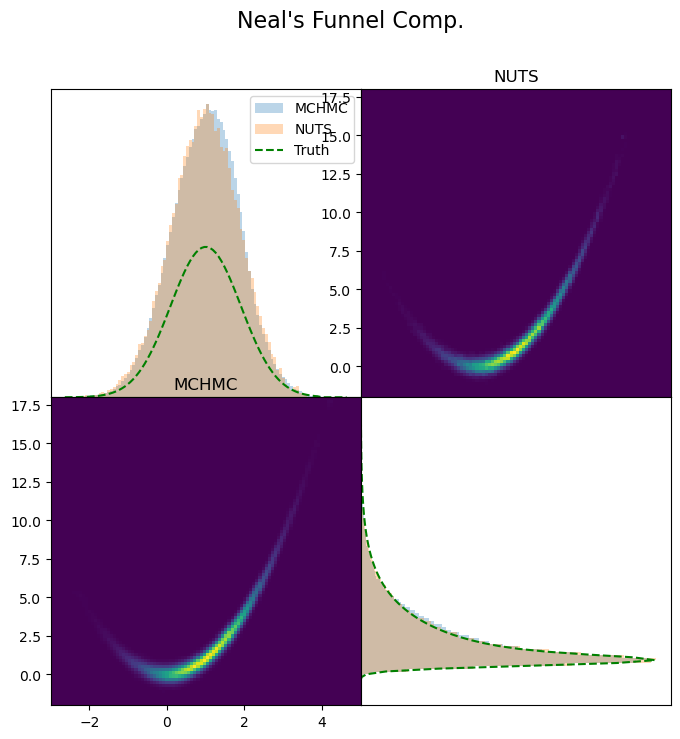

In [22]:
fig, axis = plt.subplots(2, 2, figsize=(8,8))
fig.suptitle("Neal's Funnel Comp.", fontsize=16)

fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)

axis[1,1].hist(d1_mchmc, bins=100, density=true, range=[-3,5], alpha = 0.3, label="MCHMC")
axis[1,1].hist(d1_hmc, bins=100, density=true, range=[-3,5], alpha = 0.3, label="NUTS")
axis[1,1].plot(X, d1_truth, "g--", label="Truth")
axis[1,1].legend()
axis[1,1].set_yticks([])

axis[2,2].hist(d2_mchmc, bins=100, density=true, orientation="horizontal", range=[-2, 18], alpha = 0.3)
axis[2,2].hist(d2_hmc, bins=100, density=true, orientation="horizontal", range=[-2, 18], alpha = 0.3)
axis[2,2].plot(d2_truth, Y, "g--", label="Truth")
axis[2,2].set_xticks([])
axis[2,2].set_yticks([])

axis[1,2].hist2d(d1_hmc, d2_hmc, bins=100, range=[[-3,5],[-2, 18]])
axis[1,2].set_title("NUTS")

axis[2,1].hist2d(d1_mchmc, d2_mchmc, bins=100, range=[[-3,5],[-2, 18]])
axis[2,1].set_title("MCHMC")
;